In [1]:
source("~/smartas/pipeline/scripts/variablesAndFunctions.r")
options(repr.plot.width=10, repr.plot.height=8)

switches.split <- read_tsv("../data/pancancer/candidateList_full.tumorSplit.tsv")

switches <- read_tsv("../data/pancancer/candidateList_full.tsv") %>%
    filter(Reliable==1)

drivers <- read_tsv("../data/intogen_cancer_drivers-2014.12b/Mutational_drivers_per_tumor_type.tsv",comment="#") %>% 
    select(geneHGNCsymbol) %>%
    unique


Attaching package: ‘dplyr’

The following objects are masked from ‘package:plyr’:

    arrange, count, desc, failwith, id, mutate, rename, summarise,
    summarize

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



# Figure 1
## Figure 1a

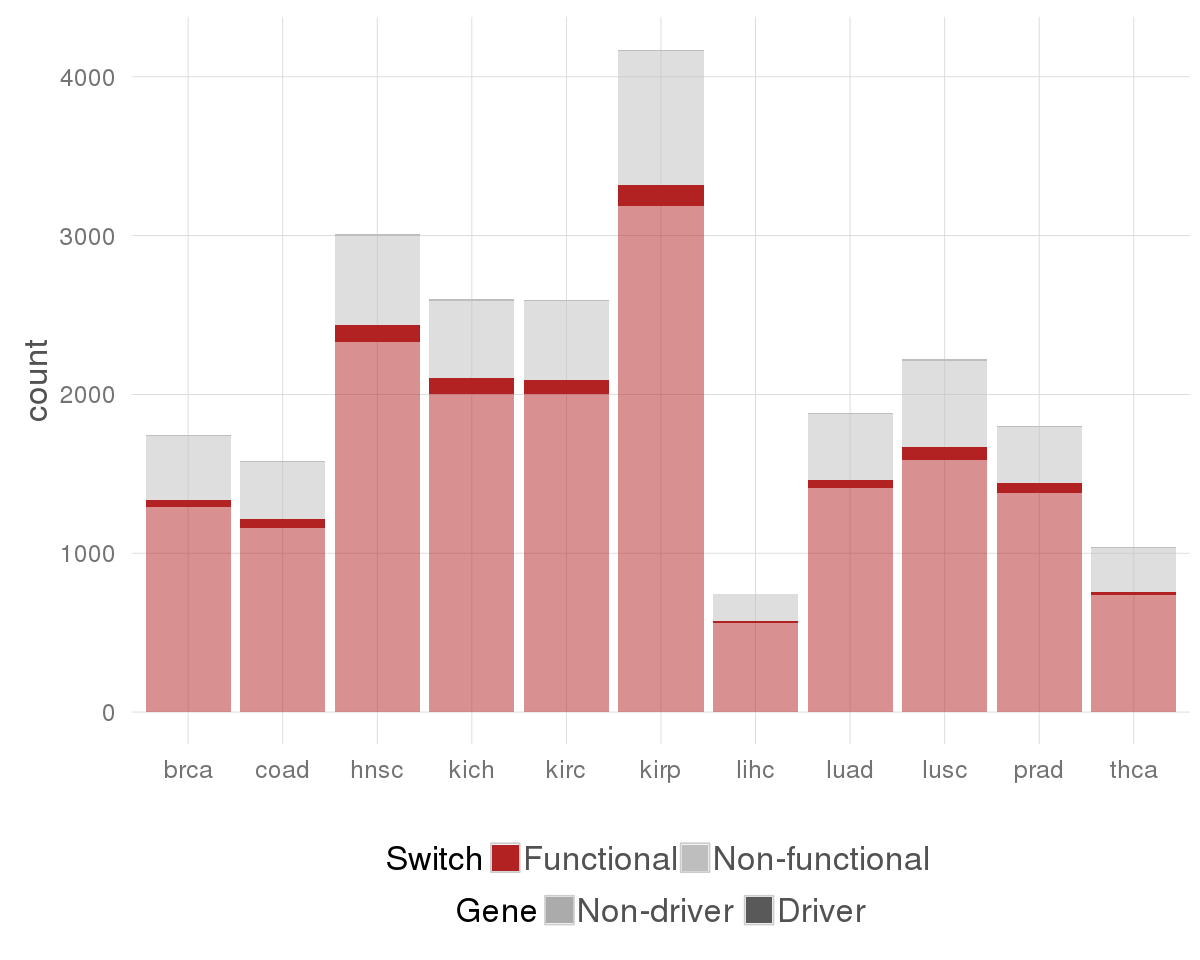

In [2]:
switches.split  %>%
    filter(NotNoise==1 & IsModel==1) %>%
    mutate(Driver = ifelse(Symbol %in% drivers$geneHGNCsymbol, "1", "0"),
           Driver = revalue(Driver, c("1"="Driver", "0"="Non-driver")),
           Driver = factor(Driver, levels=c("Non-driver","Driver")),
           IsFunctional = revalue(as.character(IsFunctional), c("1"="Functional", "0"="Non-functional"))) %>%
    ggplot(aes(x=Tumor, fill=IsFunctional, alpha=Driver)) +
        geom_bar() +
        labs(x="", fill="Switch", alpha="Gene") +
        scale_fill_manual(values=c("Functional"="firebrick", "Non-functional"="gray")) +
        scale_alpha_manual(values=c("Driver"=1, "Non-driver"=0.5)) +
        smartas_theme() +
        theme(legend.position="bottom")

Number of switches (y axis) calculated in each tumor type (x axis), separated according to whether the switches are functional or not.
## Figure 1b

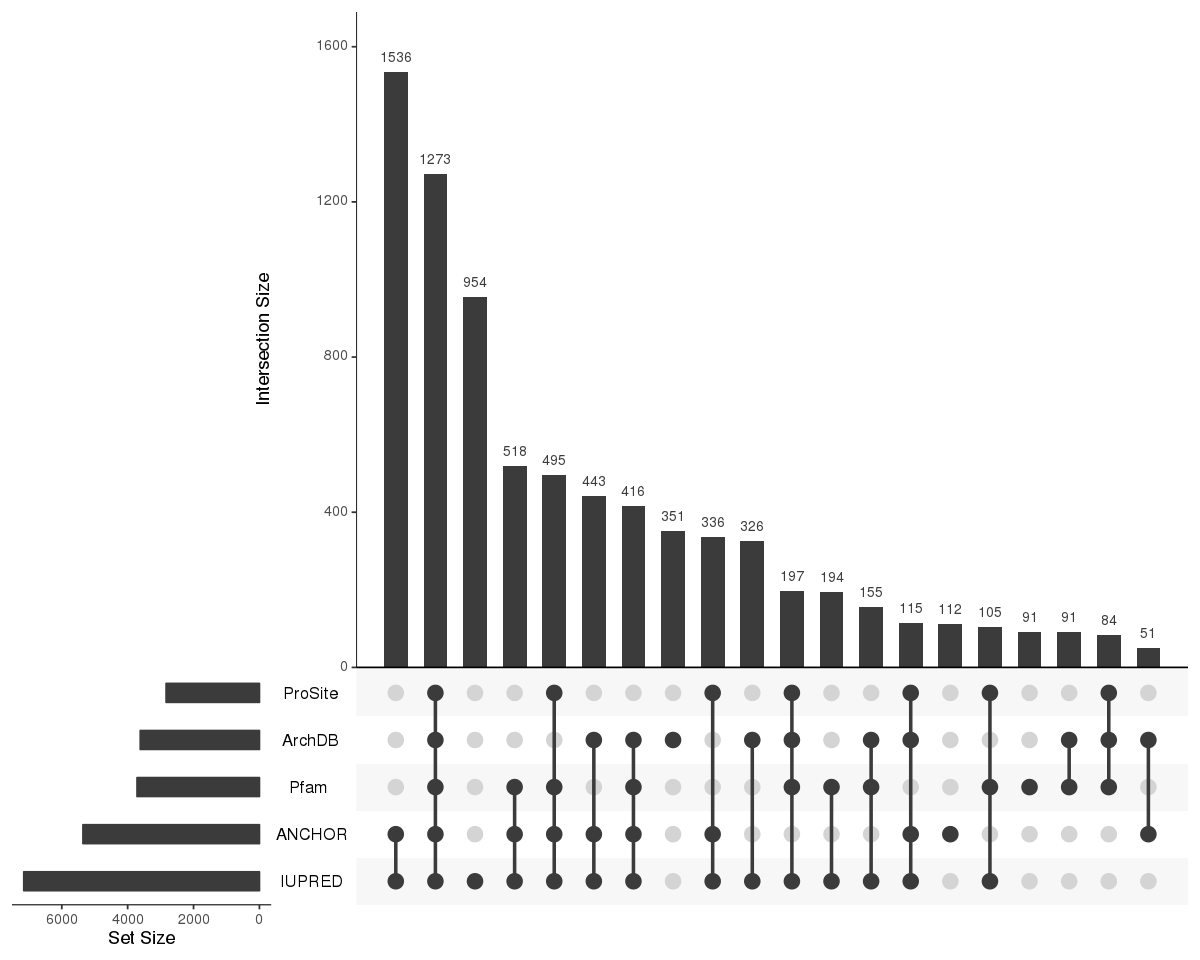

In [3]:
library(UpSetR)

structural <- lapply(cancerTypes, function(tumor){
    paste0("../data/structural_analysis/",tumor,".structural_summary.tsv") %>%
    read_tsv %>%
    set_colnames(c('GeneId','Symbol','Normal_transcript','Tumor_transcript',
                   'ArchDB','Pfam','IUPRED','ANCHOR','ProSite')) %>%
    mutate(ArchDB = ifelse(ArchDB=="True",1,0),
           Pfam = ifelse(Pfam=="True",1,0),
           IUPRED = ifelse(IUPRED=="True",1,0),
           ANCHOR = ifelse(ANCHOR=="True",1,0),
           ProSite = ifelse(ProSite=="True",1,0))
}) %>% do.call("rbind",.) %>%
    unique %>%
    merge(switches)

structural %>%
    select(ArchDB,Pfam,IUPRED,ANCHOR,ProSite) %>%
    # top 20 intersections
    upset(order.by = "freq", nintersects = 20)

Overlap graph of protein features affected in functional switches.
## Figure 1c

Mutational cancer drivers (Methods) with multiple transcript isoforms show enrichment of functional switches compared to other genes with similar characteristics.
## Figure 1d

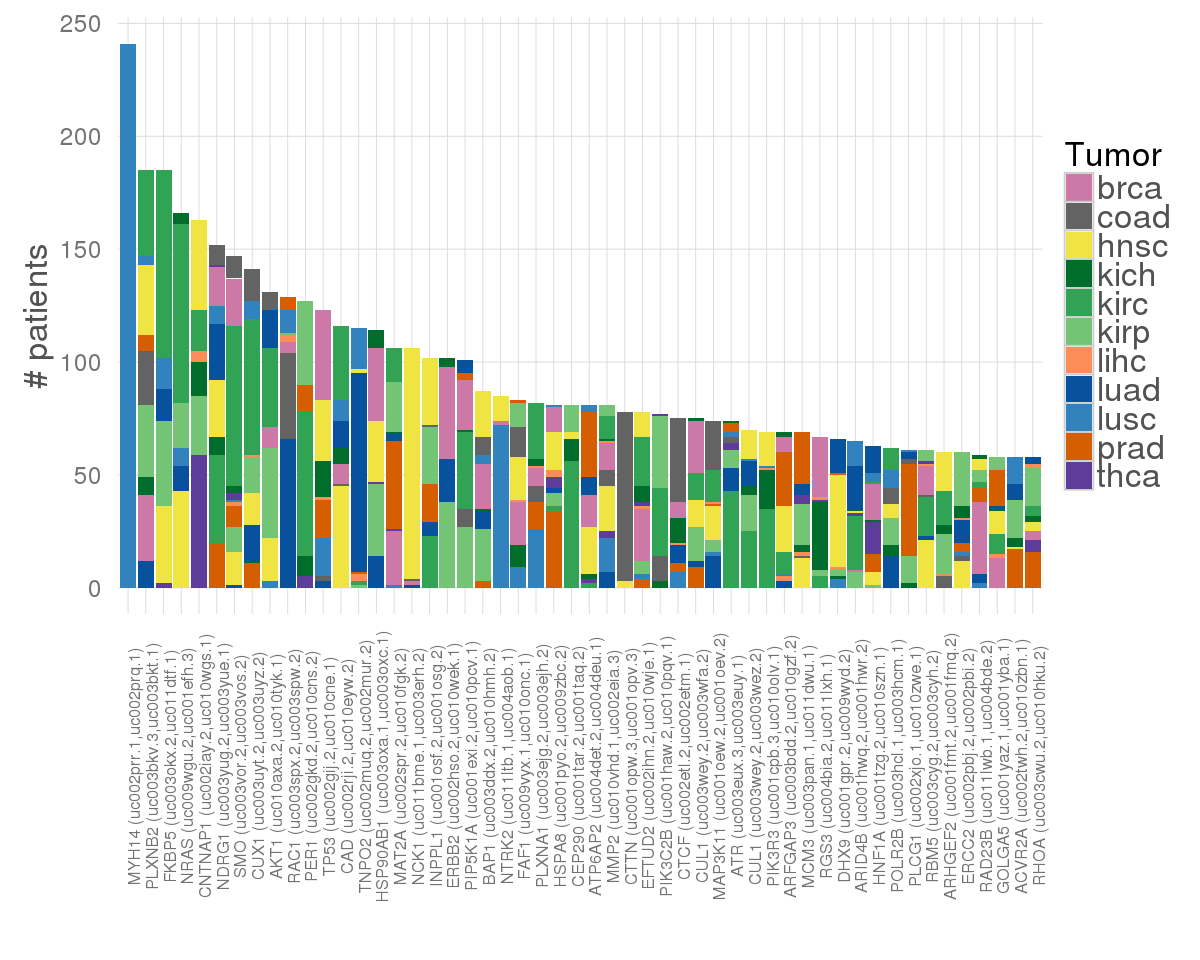

In [4]:
top50.drivers <- switches %>%
    filter(Symbol %in% drivers$geneHGNCsymbol) %>%
    arrange(desc(PatientNumber)) %>%
    top_n(50, PatientNumber) %>%
    mutate(label = paste0(Symbol," (",Normal_transcript,",",Tumor_transcript,")")) %>%
    select(Normal_transcript,Tumor_transcript,label)

merge(top50.drivers, switches.split) %>%
    mutate(label = factor(label, levels=top50.drivers$label)) %>%
    ggplot(aes(x=label, y=PatientNumber, fill=Tumor)) +
        geom_bar(stat="identity") +
        labs(x="", y="# patients") +
        scale_fill_manual(values=colorPalette) +
        smartas_theme() +
        theme(legend.position="right", axis.text.x = element_text(angle = 90, size=10))

Top 50 functional switches in mutational cancer drivers according to the number of patients in which they occur. We indicate in color the tumor type. 
# Figure 2
## Figure 2a

Enrichment of functional domains in drivers.